### Alvaro Plata (201820098), Brenda Barahona (201812721) , Sofía Álvarez (201729031)

<h1 align='center'>Laboratorio 2: Inteligencia de Negocios</h1>

BancAlpes es una entidad bancaria que está realizando una campaña de fidelización para aumentar la retención de clientes. En concreto, con su estrategía busca fidelizar especialmente a las personas que poseen tarjetas de crédito.
Esta campaña busca ofrecer los mejores productos, servicios y recomendaciones a sus clientes de acuerdo con sus características.
Por esta razón, ha recurrido a ustedes como consultores para que le entreguen al equipo de marketing información que pueda ayudarlos a orientar mejor sus campañas.
En particular, el equipo de marketing espera que le provean grupos a los cuales pueden dirigir sus campañas y las caracteristicas de los clientes en dichos grupos.
BancAlpes considera que esta nueva estrategia de marketing le permitirá aumentar el consumo de productos y servicios y por supuesto, aumentar la retención de clientes.

## 0. Librerias.

In [7]:
# ESAI
# Importamos todas las librerias necesarias para el laboratorio.
import re
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from joblib import dump, load
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from pandas_profiling import ProfileReport
from sklearn.pipeline import Pipeline, FeatureUnion
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.metrics import recall_score, make_scorer
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

### 1. Análisis exploratorio y perfilamiento de los datos.

En esta etapa sabremos cuántos datos tenemos (filas y columnas), el tipo de datos de las columnas, cual es la integridad de los datos, cuál es su distribución (discreta o continua). Ademas, para el caso de las columnas numéricas, usaremos estadística descriptiva sobre los datos, y señalaremos sus principales estadísticos: media, varianza, desviación estándar, etc.  En caso de datos categóricos conoceremos las categorías, los números de registro por categoría, en especial para las categorías con mayor representación en los datos.

Primero leemos los datos y sacamos una muestra, como se ve a continuación:

In [8]:
datos = pd.read_csv('202210_Laboratorio2_data_202210_Lab2_BancAlpes_CC_data.csv', delimiter=',')
datos.sample(5)

CUST_ID GENDER      BALANCE  PURCHASES  BALANCE_FREQUENCY CASH_ADVANCE  \
4765  C12113    NaN  1294.258830       0.00           1.000000    92.841595   
993   C15028    NaN    22.322215     448.00           0.363636          0.0   
2258  C12627      M  1055.833418     351.54           1.000000          0.0   
4724  C15747      M  2638.453830       0.00           1.000000   262.082802   
1939  C18280      F   617.496041     521.64        1000.000000          0.0   

      CASH_ADVANCE_TRX  PURCHASES_FREQUENCY PURCHASES_TRX  \
4765               1.0             0.000000             0   
993                0.0             0.333333             5   
2258               0.0             1.000000            13   
4724               2.0             0.000000             0   
1939               0.0             1.000000            12   

      ONEOFF_PURCHASES_FREQUENCY  CASH_ADVANCE_FREQUENCY  CREDIT_LIMIT  \
4765                    0.000000                0.083333        1500.0   
993                     0.083333                0.000000        3000.0   
2258                    0.083333                0.000000        3000.0   
4724                    0.000000                0.166667        2900.0   
1939                    0.000000                0.000000        1500.0   

         PAYMENTS MINIMUM_PAYMENTS TENURE  
4765   308.886492       468.194223     12  
993   1262.320878       132.889435     12  
2258   585.022975       251.539573     12  
4724   642.830286       599.508236     12  
1939   269.919412       234.724653     12

In [9]:
print("Número de filas o datos: {}".format(len(datos)))
print("Número de columnas o variables: {}".format(len(datos.columns)))

Número de filas o datos: 5530
Número de columnas o variables: 15


Para conocer el tipo de datos de las columnas, cual es la integridad de los datos, cuál es su distribución (discreta o continua), procedemos a hacer el reporte de <code>pandas_profiling:</code>

In [6]:
profiling = ProfileReport(datos)
profiling.to_file(output_file="pandas_profiling.html")
profiling

Summarize dataset:   0%|          | 0/28 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Análisis del reporte: 
Puntualmente pudimos encontrar los siguientes datos: 
* No hay celdas duplicadas. 
* Tenemos un porcentaje de celdas vacías o NA de 7.2%, lo cual representan 5933 celdas.
* Las variables que tienen valores vacios son: 
    
    1. OneOffPurchases_frecuency con un 49.5% con 2740 celdas vacías
    2. Gender con un 49.1% con 2714 celdas vacías
    3. Cash_advance_frecuency con un 3% con 166 celdas vacías
    4. Tenure con un 2.9% con 163 celdas vacías
    5. Cash_Advance_Trx con un 2.7% con 150 celdas vacías
    
    
* Se tienen 9 variables numéricas y 6 categóricas. Esto NO concuerda con el diccionario dado por BancAlpes. Encontramos queel tipo de dato identificado por pandas profiling es incorrecto para las siguientes variables, según lo indicado por el documento del diccionario, pues estas variable deben ser numéricas y fueron clasificadas como categóricas: 

    1. CashAdvance
    2. PurchasesTrx
    3. Minimum_payments
    4. Tenure
    
Esto último se debe a que hay algunos datos con inconsistencias o datos atípicos.
    
* Evidenciamos que de las variables numéricas, aquellas que tienen una distribución continua son :
    1. Balance
    2. Purchases
    3. OneOffPurchasesFrecuency
    4. Cash_advanceFrecuency
    5. Credit_limit 
    6. Payments
    
    
* Ademas de las variables antes mencionadas, encontramos que hay otras que tambien siguen una distrubición continua y que, debido a los outliers, no se evidenciaba una clara distribucion de los datos, ya que los rangos con los que pandas contruyó el histograma eran muy grandes.

* Descubrimos que las siguientes variables tienen datos atipicos. 
    1. Balance: datos fuera de rango. 
    2. Balance_frecuency: datos fuera de rango.
    3. Cash_advance: datos como ["??", "00.?ñ" , ...]
    4. Cash_advance_trx: datos fuera de rango. 
    5. Purchases_Frecuency: datos fuera de rango
    6. Cash_advance_frecuency: datos fuera de rango
    7. Credit_limit: datos fuera de rango
    8. Minimum_payments: datos como ["??", ...]
    
    

    
 

Para las columnas numéricas usaremos estadística descriptiva sobre los datos.

In [10]:
datos.describe()

BALANCE    PURCHASES  BALANCE_FREQUENCY  CASH_ADVANCE_TRX  \
count  5530.000000  5530.000000        5530.000000       5380.000000   
mean   1041.700463   534.577103          26.482552         49.115428   
std    1353.093044   773.488745         152.899316        573.817771   
min   -4587.892398     0.000000           0.000000          0.000000   
25%      74.060304     0.000000           0.833333          0.000000   
50%     632.743635   269.130000           1.000000          0.000000   
75%    1545.808455   723.700000           1.000000          3.000000   
max    7390.198560  9661.370000        1000.000000      18000.000000   

       PURCHASES_FREQUENCY  ONEOFF_PURCHASES_FREQUENCY  \
count          5530.000000                 2790.000000   
mean             12.206006                    0.148298   
std              93.757671                    0.241687   
min               0.000000                    0.000000   
25%               0.000000                    0.000000   
50%               0.363636                    0.000000   
75%               0.833333                    0.166667   
max            1000.000000                    1.000000   

       CASH_ADVANCE_FREQUENCY  CREDIT_LIMIT     PAYMENTS  
count             5364.000000   5530.000000  5530.000000  
mean                 0.119005   3588.095256  1107.989817  
std                  0.173206   2640.396238  1270.892564  
min                  0.000000     50.000000     0.056466  
25%                  0.000000   1500.000000   345.431102  
50%                  0.000000   2900.000000   671.001699  
75%                  0.166667   5000.000000  1354.931507  
max                  1.500000  12500.000000  9933.622610

En caso de datos categóricos según el diccionario conoceremos las categorías, los números de registro por categoría, en especial para las categorías con mayor representación en los datos

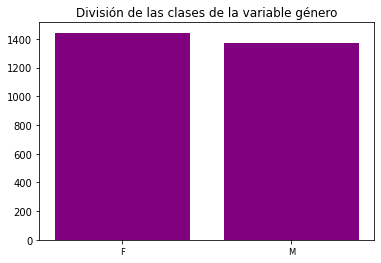

Veamos la cantidad de datos en cada clase: 


GENDER
F    1443
M    1373

In [11]:
val_counts_gender = datos['GENDER'].value_counts()
plt.bar(range(len(val_counts_gender)), val_counts_gender.values, align='center',color='purple')
plt.xticks(range(len(val_counts_gender)), val_counts_gender.index.values, size='small')
plt.title('División de las clases de la variable género')
plt.show()
print('Veamos la cantidad de datos en cada clase: ')
datos['GENDER'].value_counts().to_frame()

Podemos ver que hay una cantidad de datos de cada categoria muy parecida. 

## 2. Preparación de datos.

Realizaremos el proceso para garantizar la calidad de los datos. 

### Eliminación de columnas 

La columna CUSTID es la identificacion de la tarjeta de crédito. Como esta columna no representa ningún dato significativo para el proceso de la creación del modelo, procedemos a eliminarla. Esto se debe a que los IDs no son relevantes en la mayoría de trabajos de aprendizaje automático. 

Como se indicó en el perfilamiento de los datos, las columnas OneOffPurchases_frecuency y Gender cuentan con un porcentaje de celdas faltantes significativo: 49.5% y 49.1% respectivamente. Por esta razón si realizamos imputación de datos para estas columnas, estaríamos sesgando los datos, por lo que también serán eliminadas.

In [12]:
datos = datos.drop(["GENDER", "CUST_ID", "ONEOFF_PURCHASES_FREQUENCY"], axis=1)
print("Número de filas o datos: {}".format(len(datos)))
print("Número de columnas o variables: {}".format(len(datos.columns)))

Número de filas o datos: 5530
Número de columnas o variables: 12


### Manejo de valores atipicos / no válidos
Primero, revisaremos cuales son los datos no válidos que tenemos en los datos.

In [13]:
def get_values_not_number(datos):
    # Vemos todos los valores distintos (únicos) que tiene el dataframe.
    valores_distintos = list(datos.apply(pd.value_counts).index)
    valores_no_numericos = []
    # Interamos sobre los valores distintos
    for val in valores_distintos:
        try:
            # Intentamos hacer el cast a float
            numero = float(val)
        except:
            # Si hay datos no numericos, los agregamos a la lista
            valores_no_numericos.append(val)
    return valores_no_numericos

In [14]:
valores_no_numericos=get_values_not_number(datos)
print('Los valores no numéricos son: {}'.format(valores_no_numericos))

Los valores no numéricos son: ['0.0?ñ', '0?ñ', '1.721007?ñ', '1090.811625?ñ', '10?ñ', '1117.265123?ñ', '117.258435?ñ', '11?ñ', '120.178123?ñ', '1210.778254?ñ', '1222.355238?ñ', '1227.092304?ñ', '1232.547913?ñ', '1253.401339?ñ', '1254.849545?ñ', '1265.552953?ñ', '127.542299?ñ', '1297.077512?ñ', '1299.253842?ñ', '12?ñ', '130.626533?ñ', '1344.577203?ñ', '135.26688?ñ', '139.382867?ñ', '1414.866215?ñ', '1452.265916?ñ', '1454.215974?ñ', '1460.777849?ñ', '147.347019?ñ', '1480.171443?ñ', '149.110815?ñ', '14?ñ', '1516.892745?ñ', '158.851964?ñ', '15?ñ', '162.269258?ñ', '162.941232?ñ', '163.353616?ñ', '167.584529?ñ', '168.805075?ñ', '1708.514116?ñ', '172.574308?ñ', '175.755159?ñ', '178.143055?ñ', '178.313275?ñ', '17?ñ', '18.904244?ñ', '183.230915?ñ', '184.288462?ñ', '185.805592?ñ', '1863.759832?ñ', '188.591146?ñ', '1983.897997?ñ', '19?ñ', '1?ñ', '200.254118?ñ', '202.991548?ñ', '216.195821?ñ', '21?ñ', '229.289946?ñ', '229.94082?ñ', '22?ñ', '233.788637?ñ', '234.095576?ñ', '237.378894?ñ', '239.60665

Podemos ver que la mayoria de estos datos no válidos tienen un número y al final un "?ñ", asumiremos que esto fue un error de tipeo al momento de ingresar los datos, por lo que eliminaremos el "?ñ" y dejaremos el número. Mas adelante revisaremos si los datos cumplen con los rangos establecida. 

La siguiente funcion nos ayudará a limpiar estos datos

In [15]:
# Function to clean the names-https://www.geeksforgeeks.org/replace-values-in-pandas-dataframe-using-regex/
def Clean_numbers(Column_name):

    if re.search('\?ñ', Column_name): 
        # Extract the position of beginning of pattern
        pos = re.search('\?ñ', Column_name).start()
        # return the cleaned name
        return Column_name[:pos]
  
    else:
        # if clean up needed return the same name
        return Column_name

Aplicamos la funcion anterior en todas las columnas. Como estamos trabajando con expresiones regulares, evitaremos errores, se convierten todos valores a <code>str</code>
Cabe resaltar que mas adelante se realizará la debida transformación a <code>float</code>.

In [16]:
for column in datos.columns:
    # Updated the columns
    datos[column]=datos[column].apply(str)
    datos[column] = datos[column].apply(Clean_numbers)
datos

BALANCE PURCHASES BALANCE_FREQUENCY CASH_ADVANCE  \
0             107.944741    118.16             0.875   472.818286   
1             241.032979       0.0               1.0   642.862505   
2      894.3578570000001    1164.0               1.0          0.0   
3            -188.132508    515.88               1.0          0.0   
4            3881.679582     15.92               1.0  2183.782456   
...                  ...       ...               ...          ...   
5525           656.01301       0.0            1000.0  1474.349901   
5526  15.232504999999998     384.0          0.272727          0.0   
5527         1023.124791   1537.93               1.0    247.04197   
5528          957.010021     604.8               1.0   901.754709   
5529  2664.7004239999997    715.51               1.0   494.573662   

     CASH_ADVANCE_TRX PURCHASES_FREQUENCY PURCHASES_TRX  \
0                 1.0               0.125             2   
1                 1.0                 0.0             0   
2                 0.0                 1.0            12   
3                 nan            0.833333            14   
4                 9.0            0.083333             1   
...               ...                 ...           ...   
5525              3.0                 0.0             0   
5526              0.0                 1.0            12   
5527              1.0                0.75            25   
5528              3.0                 1.0            12   
5529              1.0               750.0            11   

     CASH_ADVANCE_FREQUENCY CREDIT_LIMIT           PAYMENTS MINIMUM_PAYMENTS  \
0                     0.125       2500.0         192.781455        56.999671   
1                  0.083333       1500.0  915.4543050000001       195.162256   
2                       0.0       2000.0  907.6037230000001       270.413449   
3                       0.0       2700.0         601.729266       194.534934   
4                  0.333333       5500.0        1032.183632      1129.747227   
...                     ...          ...                ...              ...   
5525                  0.125       7000.0         910.457985       140.983193   
5526                    0.0       1500.0         568.982664        54.449416   
5527               0.083333       9000.0        1070.149971       235.241959   
5528               0.083333       1000.0  811.4571900000001       926.087148   
5529               0.083333       3500.0  918.0030320000001       792.902894   

     TENURE  
0         8  
1        12  
2       -12  
3        12  
4        12  
...     ...  
5525      8  
5526     12  
5527    -12  
5528     12  
5529     12  

[5530 rows x 12 columns]

Ahora, rectificaremos que efectivamente los datos que tenian los caracteres "?ñ" fueron corregidos 

In [17]:
valores_no_numericos=get_values_not_number(datos)
print('Los valores no numéricos ahora son: {}'.format(valores_no_numericos))

Los valores no numéricos ahora son: ['??']


In [18]:
num_inconsistentes = len(datos[(datos.values == '??').any(axis=1)])
print('El número de filas con datos inconsistentes es: {}'.format(num_inconsistentes))
print ("Esto representa el: {:.2f}% de los datos".format(num_inconsistentes/len(datos)*100))

El número de filas con datos inconsistentes es: 291
Esto representa el: 5.26% de los datos


Para evitar eliminar el 5% de los datos, estos se convertirán en datos NaN y serán manejados en mas adelante.
Para esto, usaremos una funcion que nos convertirá todo lo que no se pueda convertir a <code>float</code> a NaN. Es una función parecida a la trabajada anteriormente, por lo que sabemos con seguridad que los unicos datos que evitan que estas columnas se puedan convertir a <code>float</code> son los "??". 

Adicionalmente, esta función ayudará a realizar la conversion de las columnas a <code>float</code>

In [19]:
def convert_to_NaN(x):
    try:
        return float(x)
    except:
        return np.NaN

In [20]:
for column in datos.columns:
    datos[column] = datos[column].apply(convert_to_NaN)
datos

BALANCE  PURCHASES  BALANCE_FREQUENCY  CASH_ADVANCE  \
0      107.944741     118.16           0.875000    472.818286   
1      241.032979       0.00           1.000000    642.862505   
2      894.357857    1164.00           1.000000      0.000000   
3     -188.132508     515.88           1.000000      0.000000   
4     3881.679582      15.92           1.000000   2183.782456   
...           ...        ...                ...           ...   
5525   656.013010       0.00        1000.000000   1474.349901   
5526    15.232505     384.00           0.272727      0.000000   
5527  1023.124791    1537.93           1.000000    247.041970   
5528   957.010021     604.80           1.000000    901.754709   
5529  2664.700424     715.51           1.000000    494.573662   

      CASH_ADVANCE_TRX  PURCHASES_FREQUENCY  PURCHASES_TRX  \
0                  1.0             0.125000            2.0   
1                  1.0             0.000000            0.0   
2                  0.0             1.000000           12.0   
3                  NaN             0.833333           14.0   
4                  9.0             0.083333            1.0   
...                ...                  ...            ...   
5525               3.0             0.000000            0.0   
5526               0.0             1.000000           12.0   
5527               1.0             0.750000           25.0   
5528               3.0             1.000000           12.0   
5529               1.0           750.000000           11.0   

      CASH_ADVANCE_FREQUENCY  CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  \
0                   0.125000        2500.0   192.781455         56.999671   
1                   0.083333        1500.0   915.454305        195.162256   
2                   0.000000        2000.0   907.603723        270.413449   
3                   0.000000        2700.0   601.729266        194.534934   
4                   0.333333        5500.0  1032.183632       1129.747227   
...                      ...           ...          ...               ...   
5525                0.125000        7000.0   910.457985        140.983193   
5526                0.000000        1500.0   568.982664         54.449416   
5527                0.083333        9000.0  1070.149971        235.241959   
5528                0.083333        1000.0   811.457190        926.087148   
5529                0.083333        3500.0   918.003032        792.902894   

      TENURE  
0        8.0  
1       12.0  
2      -12.0  
3       12.0  
4       12.0  
...      ...  
5525     8.0  
5526    12.0  
5527   -12.0  
5528    12.0  
5529    12.0  

[5530 rows x 12 columns]

In [21]:
print(datos.dtypes)

BALANCE                   float64
PURCHASES                 float64
BALANCE_FREQUENCY         float64
CASH_ADVANCE              float64
CASH_ADVANCE_TRX          float64
PURCHASES_FREQUENCY       float64
PURCHASES_TRX             float64
CASH_ADVANCE_FREQUENCY    float64
CREDIT_LIMIT              float64
PAYMENTS                  float64
MINIMUM_PAYMENTS          float64
TENURE                    float64
dtype: object


### Manejo de valores fuera de rango

En el perfilamiento de datos identificamos algunas variables tienen valores fuera de rango según el diccionario por BancAlpes. Sin emabargo, revisaremos si hay otras variables que presenten valores fuera de rango. 

In [22]:
print ("{:<25} {:<15} {:<10}".format('VARIABLE','MIN','MAX',))
print ("------------------------------------------------------")
for column in datos.columns:
    print ("{:<25} {:<15} {:<10}".format( column, datos[column].min(),datos[column].max()))

VARIABLE                  MIN             MAX       
------------------------------------------------------
BALANCE                   -4587.892398    7390.19856
PURCHASES                 0.0             9661.37   
BALANCE_FREQUENCY         0.0             1000.0    
CASH_ADVANCE              0.0             6448.247202
CASH_ADVANCE_TRX          0.0             18000.0   
PURCHASES_FREQUENCY       0.0             1000.0    
PURCHASES_TRX             0.0             28000.0   
CASH_ADVANCE_FREQUENCY    0.0             1.5       
CREDIT_LIMIT              50.0            12500.0   
PAYMENTS                  0.056465999999999995 9933.622609999999
MINIMUM_PAYMENTS          0.019163        1998.400995
TENURE                    -12.0           12.0      


Con esta información podemos ver que las variables que tienen datos fuera de rango son:
1. Fuera de límite superior 
    * CASH_ADVANCE:Debe ser [0,5000]
    * CASH_ADVANCE_TRX: Debe ser [0,15]
    * PURCHASES_FREQUENCY: Debe ser [0,1]
    * PURCHASES_TRX: Debe ser [0,30] 
    * CASH_ADVANCE_FREQUENCY:  Debe ser [0,1] 
    * CREDIT_LIMIT:Debe ser [0,10000]
    * MINIMUM_PAYMENTS:Debe ser [0,1200]


2. Fuera del límite inferior
    * TENURE:Debe ser [1,12]



3. Fuera de ambos límites
    * BALANCE: Debe ser [0,5000]. De acuerdo con los expertos del negocio, no puede haber balances negativos. No obstante, asumimos que el máximo valor positivo de balance es correcto.
    


In [34]:
datos['BALANCE_FREQUENCY'][datos['BALANCE_FREQUENCY']>1].value_counts()

1000.000    111
909.091       9
818.182       7
636.364       6
545.455       4
363.636       4
272.727       3
727.273       3
181.818       3
454.545       3
857.143       2
833.333       1
428.571       1
333.333       1
888.889       1
285.714       1
Name: BALANCE_FREQUENCY, dtype: int64

Procederemos a contar cuantos datos fuera de rango hay para cada columna. 

In [18]:
dic_limites={"BALANCE":(0,5000),"CASH_ADVANCE":(0,5000),"CASH_ADVANCE_TRX":(0,15),"PURCHASES_FREQUENCY":(0,1),"PURCHASES_TRX":(0,30),"CASH_ADVANCE_FREQUENCY":(0,1),"CREDIT_LIMIT":(0,10000),"MINIMUM_PAYMENTS":(0,1200),"TENURE":(1,12)}
#El diccionario de parámetro debe ser {"nombreColumna": (valor minimo aceptado, valor máximo aceptado)}
def obtener_numero_outliers (diccionario):
    print ("Datos fuera de rango para:")
    total=0
    for column in dic_limites.keys():
        lim_inf=len(datos[datos[column]<dic_limites[column][0]])
        lim_sup=len(datos[datos[column]>dic_limites[column][1]])
        print ("{:<25} {:<10}".format (column, lim_inf+ lim_sup))
        total+=lim_inf+lim_sup

    #print("En total hay {} celdas de datos fuera del rango, esto representa el {:.2f}% de las celdas en el dataframe".format(total, total/(datos.shape[0]*datos.shape[1])*100))
    print("En total hay {} datos fuera del rango, esto representa el {:.2f}%  en el dataframe".format(total, total/(len(datos))*100))   

In [19]:
obtener_numero_outliers(dic_limites)

Datos fuera de rango para:
BALANCE                   291       
CASH_ADVANCE              68        
CASH_ADVANCE_TRX          158       
PURCHASES_FREQUENCY       117       
PURCHASES_TRX             116       
CASH_ADVANCE_FREQUENCY    2         
CREDIT_LIMIT              136       
MINIMUM_PAYMENTS          393       
TENURE                    148       
En total hay 1429 datos fuera del rango, esto representa el 25.84%  en el dataframe


Como estos datos fuera de rango representan un porcentaje signiticativo. Manejaremos estos datos de la siguiente manera:
Para todas las columnas vamos a realizar una imputacion con la media de los datos. Esto debido a que, el porcentaje máximo de celdas a imputar por cada columna sera de de 7.23%, que corresponde al porcentaje de celdas fuera de rango de la columna que más celdas fuera de rango tiene.  Para esto, primero debemos volver nulos estos valores. (esta imputación se realizará en la siguiente sección) 


In [20]:
def tratar_outliers(x, minimo, maximo):
    if x>=minimo and x<=maximo: 
        return x
    else: 
        return np.NaN
       

In [21]:
for column in dic_limites.keys():
    datos[column] = datos[column].apply( tratar_outliers, args=(dic_limites[column][0], dic_limites[column][1]))
datos

BALANCE  PURCHASES  BALANCE_FREQUENCY  CASH_ADVANCE  \
0      107.944741     118.16           0.875000    472.818286   
1      241.032979       0.00           1.000000    642.862505   
2      894.357857    1164.00           1.000000      0.000000   
3             NaN     515.88           1.000000      0.000000   
4     3881.679582      15.92           1.000000   2183.782456   
...           ...        ...                ...           ...   
5525   656.013010       0.00        1000.000000   1474.349901   
5526    15.232505     384.00           0.272727      0.000000   
5527  1023.124791    1537.93           1.000000    247.041970   
5528   957.010021     604.80           1.000000    901.754709   
5529  2664.700424     715.51           1.000000    494.573662   

      CASH_ADVANCE_TRX  PURCHASES_FREQUENCY  PURCHASES_TRX  \
0                  1.0             0.125000            2.0   
1                  1.0             0.000000            0.0   
2                  0.0             1.000000           12.0   
3                  NaN             0.833333           14.0   
4                  9.0             0.083333            1.0   
...                ...                  ...            ...   
5525               3.0             0.000000            0.0   
5526               0.0             1.000000           12.0   
5527               1.0             0.750000           25.0   
5528               3.0             1.000000           12.0   
5529               1.0                  NaN           11.0   

      CASH_ADVANCE_FREQUENCY  CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  \
0                   0.125000        2500.0   192.781455         56.999671   
1                   0.083333        1500.0   915.454305        195.162256   
2                   0.000000        2000.0   907.603723        270.413449   
3                   0.000000        2700.0   601.729266        194.534934   
4                   0.333333        5500.0  1032.183632       1129.747227   
...                      ...           ...          ...               ...   
5525                0.125000        7000.0   910.457985        140.983193   
5526                0.000000        1500.0   568.982664         54.449416   
5527                0.083333        9000.0  1070.149971        235.241959   
5528                0.083333        1000.0   811.457190        926.087148   
5529                0.083333        3500.0   918.003032        792.902894   

      TENURE  
0        8.0  
1       12.0  
2        NaN  
3       12.0  
4       12.0  
...      ...  
5525     8.0  
5526    12.0  
5527     NaN  
5528    12.0  
5529    12.0  

[5530 rows x 12 columns]

In [22]:
obtener_numero_ouliers(dic_limites)

Datos fuera de rango para:
BALANCE                   0         
CASH_ADVANCE              0         
CASH_ADVANCE_TRX          0         
PURCHASES_FREQUENCY       0         
PURCHASES_TRX             0         
CASH_ADVANCE_FREQUENCY    0         
CREDIT_LIMIT              0         
MINIMUM_PAYMENTS          0         
TENURE                    0         
En total hay 0 datos fuera del rango, esto representa el 0.00%  en el dataframe


### Manejo de nulos (celdas vacías)

Revisaremos el numero total de celdas vacías que tenemos

In [23]:
datos_con_null = datos[datos.isna().any(axis=1)]
print('La cantidad de filas con al menos una celda vacía es: ', len(datos_con_null))
print('El porcentaje de filas con celdas vacías es del {:.2f}%'.format((len(datos_con_null)*100)/len(datos)))

La cantidad de filas con al menos una celda vacía es:  1728
El porcentaje de filas con celdas vacías es del 31.25%


Como este es un porcentaje siginiticativo de los datos, procederemos a realizar imputación de estos deacuerdo a la moda. 

In [24]:
for column in datos.columns:
    datos[column] = datos[column].replace(np.nan, datos[column].mean())
datos

BALANCE  PURCHASES  BALANCE_FREQUENCY  CASH_ADVANCE  \
0      107.944741     118.16           0.875000    472.818286   
1      241.032979       0.00           1.000000    642.862505   
2      894.357857    1164.00           1.000000      0.000000   
3      990.566892     515.88           1.000000      0.000000   
4     3881.679582      15.92           1.000000   2183.782456   
...           ...        ...                ...           ...   
5525   656.013010       0.00        1000.000000   1474.349901   
5526    15.232505     384.00           0.272727      0.000000   
5527  1023.124791    1537.93           1.000000    247.041970   
5528   957.010021     604.80           1.000000    901.754709   
5529  2664.700424     715.51           1.000000    494.573662   

      CASH_ADVANCE_TRX  PURCHASES_FREQUENCY  PURCHASES_TRX  \
0             1.000000             0.125000            2.0   
1             1.000000             0.000000            0.0   
2             0.000000             1.000000           12.0   
3             2.040023             0.833333           14.0   
4             9.000000             0.083333            1.0   
...                ...                  ...            ...   
5525          3.000000             0.000000            0.0   
5526          0.000000             1.000000           12.0   
5527          1.000000             0.750000           25.0   
5528          3.000000             1.000000           12.0   
5529          1.000000             0.425725           11.0   

      CASH_ADVANCE_FREQUENCY  CREDIT_LIMIT     PAYMENTS  MINIMUM_PAYMENTS  \
0                   0.125000        2500.0   192.781455         56.999671   
1                   0.083333        1500.0   915.454305        195.162256   
2                   0.000000        2000.0   907.603723        270.413449   
3                   0.000000        2700.0   601.729266        194.534934   
4                   0.333333        5500.0  1032.183632       1129.747227   
...                      ...           ...          ...               ...   
5525                0.125000        7000.0   910.457985        140.983193   
5526                0.000000        1500.0   568.982664         54.449416   
5527                0.083333        9000.0  1070.149971        235.241959   
5528                0.083333        1000.0   811.457190        926.087148   
5529                0.083333        3500.0   918.003032        792.902894   

         TENURE  
0      8.000000  
1     12.000000  
2     11.461165  
3     12.000000  
4     12.000000  
...         ...  
5525   8.000000  
5526  12.000000  
5527  11.461165  
5528  12.000000  
5529  12.000000  

[5530 rows x 12 columns]

In [25]:
datos_con_null = datos[datos.isna().any(axis=1)]
print('La cantidad de filas con al menos una celda vacía es: ', len(datos_con_null))
print('El porcentaje de filas con celdas vacías es del {:.2f}%'.format((len(datos_con_null)*100)/len(datos)))

La cantidad de filas con al menos una celda vacía es:  0
El porcentaje de filas con celdas vacías es del 0.00%


### Preparacion de los datos según los modelos a usar

## 3. Modelamiento.

## 4. Validación.

## 5. Visualización.
Haremos la exportación de los datos para usar la herramienta PowerBi